In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
datasets = joblib.load("all_pollutant_datasets.pkl")

POLLUTANTS = ["PM25", "PM10", "NO2", "SO2", "O3", "CO", "NOX"]


Temporal Train / Val / Test Split

In [3]:
from pandas.tseries.offsets import DateOffset

def temporal_split(df):
    last_date = df["datetime"].max()
    test_start = last_date - DateOffset(months=6)
    val_start  = test_start - DateOffset(months=6)

    train = df[df["datetime"] < val_start]
    val   = df[(df["datetime"] >= val_start) & (df["datetime"] < test_start)]
    test  = df[df["datetime"] >= test_start]

    return train, val, test


In [4]:
BASE_FEATURES = [
    "lat", "lon",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "month", "is_weekend",
    "u", "v",
    "AT", "RH", "BP", "SolarRad", "Rain"
]

def get_feature_columns(df, target):
    lag_features = [
        c for c in df.columns
        if c.startswith(target+"_") or
           any(c.startswith(x+"_") for x in ["WS", "AT", "RH", "BP"])
    ]
    return BASE_FEATURES + lag_features


In [5]:
def scale_features(train, val, test, feature_cols):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train[feature_cols])
    X_val   = scaler.transform(val[feature_cols])
    X_test  = scaler.transform(test[feature_cols])
    return X_train, X_val, X_test, scaler


In [6]:
def create_sequences(X, y, timesteps=24):
    Xs, ys = [], []
    for i in range(timesteps, len(X)):
        Xs.append(X[i-timesteps:i])
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)


In [7]:
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2


TFT Building Blocks

#Gated Residual Network (GRN)

In [8]:
def GRN(x, units):
    dense1 = layers.Dense(units, activation="elu")(x)
    dense2 = layers.Dense(units)(dense1)
    gate   = layers.Dense(units, activation="sigmoid")(x)
    return layers.Add()([layers.Multiply()([dense2, gate]), x])


Build TFT Model

In [9]:
def build_tft(input_shape, d_model=64, num_heads=4, ff_dim=128):
    inputs = layers.Input(shape=input_shape)

    # Variable selection (learn feature importance)
    x = layers.Dense(d_model)(inputs)
    x = GRN(x, d_model)

    # Temporal attention
    attn = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=d_model
    )(x, x)

    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    # Feed-forward
    ff = layers.Dense(ff_dim, activation="relu")(x)
    ff = layers.Dense(d_model)(ff)

    x = layers.Add()([x, ff])
    x = layers.LayerNormalization()(x)

    # Pooling
    x = layers.GlobalAveragePooling1D()(x)
    output = layers.Dense(1)(x)

    model = Model(inputs, output)
    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"]
    )
    return model


Training Loop

In [10]:
results = {}
predictions = {}

for target in POLLUTANTS:
    print(f"\n===== Training TFT for {target} =====")

    df = datasets[target]
    features = get_feature_columns(df, target)

    train, val, test = temporal_split(df)

    X_train, X_val, X_test, scaler = scale_features(train, val, test, features)
    y_train, y_val, y_test = train[target], val[target], test[target]

    X_train_seq, y_train_seq = create_sequences(X_train, y_train)
    X_val_seq, y_val_seq     = create_sequences(X_val, y_val)
    X_test_seq, y_test_seq   = create_sequences(X_test, y_test)

    model = build_tft((X_train_seq.shape[1], X_train_seq.shape[2]))

    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=50,
        batch_size=128,
        callbacks=[EarlyStopping(patience=8, restore_best_weights=True)],
        verbose=1
    )

    preds = model.predict(X_test_seq).ravel()
    rmse, mae, r2 = evaluate(y_test_seq, preds)

    print(f"{target}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")

    results[target] = {"RMSE": rmse, "MAE": mae, "R2": r2}
    predictions[target] = (y_test_seq, preds)

    # Save model & scaler
    model.save(f"models/TFT_{target}.keras")
    joblib.dump(scaler, f"models/scaler_TFT_{target}.pkl")



===== Training TFT for PM25 =====
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - loss: 262.1432 - mae: 10.6776 - val_loss: 90.7257 - val_mae: 7.0738
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 169.5273 - mae: 8.5909 - val_loss: 81.0840 - val_mae: 6.6110
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 139.2563 - mae: 8.0174 - val_loss: 80.7466 - val_mae: 6.6884
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 126.3284 - mae: 7.7753 - val_loss: 75.3306 - val_mae: 6.2931
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 118.3069 - mae: 7.6165 - val_loss: 75.6514 - val_mae: 6.6329
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 111.8776 - mae: 7.4686 - val_loss: 77.5249 - val_mae: 6.4972
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 106.8301 - mae: 7.3289 - val_loss: 83.4272 - val_mae: 6.9814
Epoch 8/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 104.6134 - mae: 7.2611 - val_loss: 85.7496 - va

In [11]:
print("\n===== TFT Performance Summary =====")
for pol, m in results.items():
    print(f"{pol}: RMSE={m['RMSE']:.3f}, MAE={m['MAE']:.3f}, R²={m['R2']:.3f}")



===== TFT Performance Summary =====
PM25: RMSE=8.090, MAE=6.085, R²=0.595
PM10: RMSE=14.477, MAE=11.171, R²=0.546
NO2: RMSE=5.818, MAE=4.330, R²=0.478
SO2: RMSE=0.802, MAE=0.680, R²=0.034
O3: RMSE=7.024, MAE=5.248, R²=0.543
CO: RMSE=273.590, MAE=203.973, R²=0.190
NOX: RMSE=11.858, MAE=8.577, R²=0.466


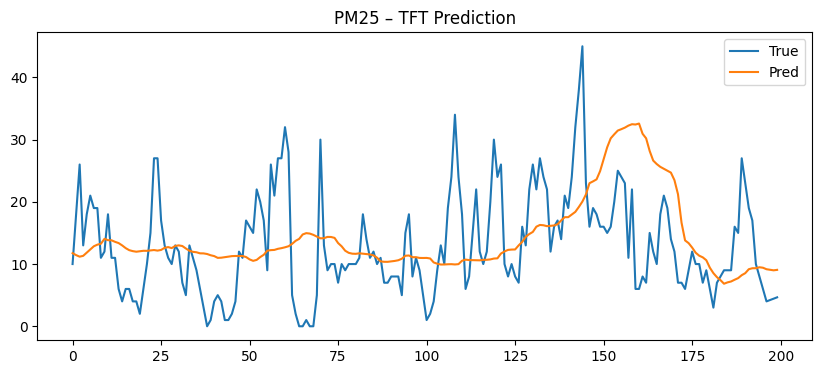

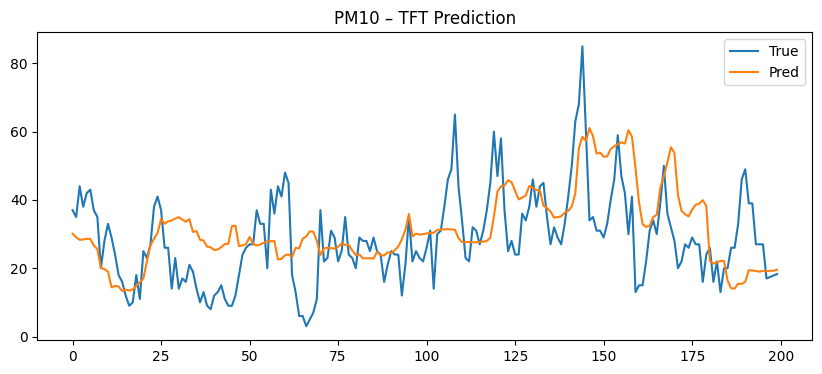

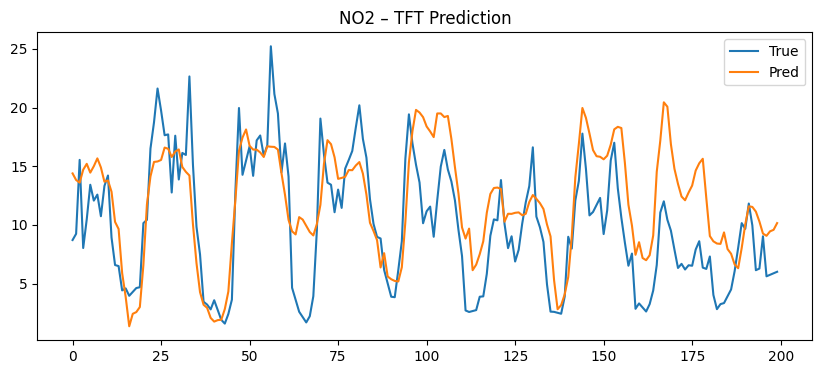

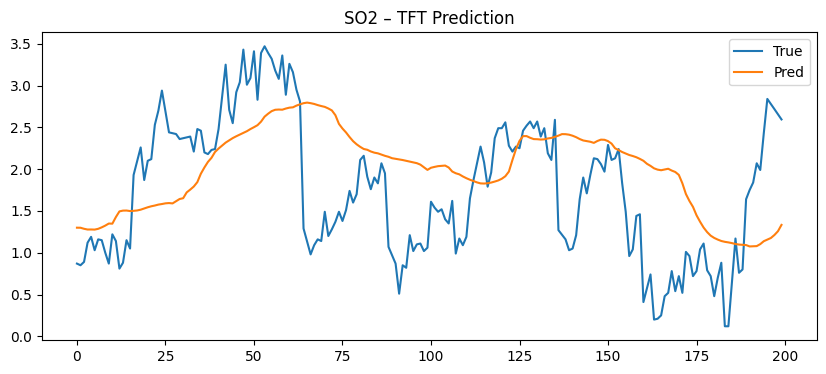

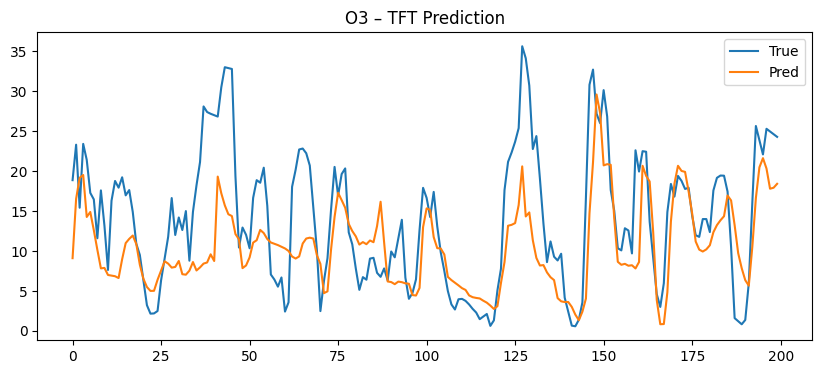

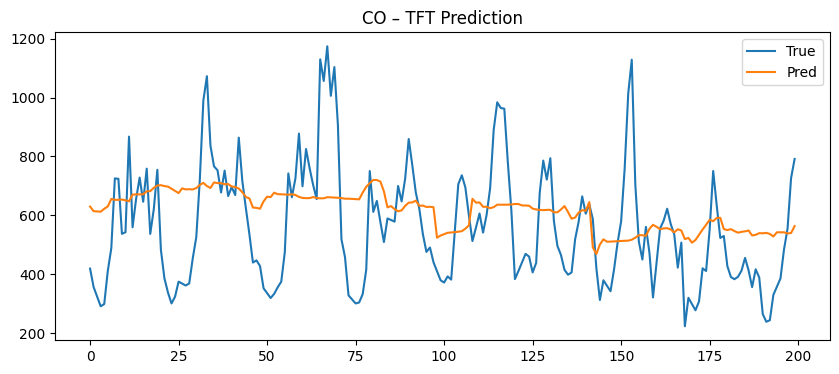

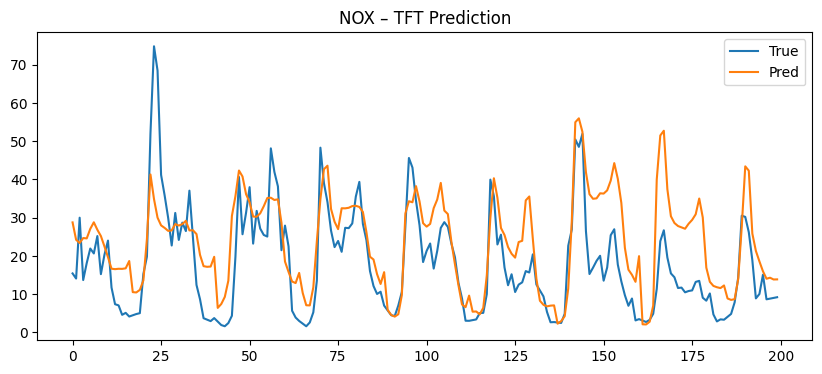

In [12]:
for pol in POLLUTANTS:
    y_true, y_pred = predictions[pol]
    plt.figure(figsize=(10,4))
    plt.plot(y_true[:200], label="True")
    plt.plot(y_pred[:200], label="Pred")
    plt.title(f"{pol} – TFT Prediction")
    plt.legend()
    plt.show()
